In [25]:
import pandas as pd

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

######################################################################33

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low
    
######################################################################33

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

######################################################################

covidstat = pd.read_csv("./data/province_covidstat.csv")
datapaper = pd.read_csv("./data/particulate.csv", sep=";")

print(covidstat.columns)
print(datapaper.columns)

Index(['Unnamed: 0', 'index', 'data', 'stato', 'codice_regione',
       'denominazione_regione', 'codice_provincia', 'denominazione_provincia',
       'sigla_provincia', 'lat', 'long', 'totale_casi', 'note',
       'codice_nuts_1', 'codice_nuts_2', 'codice_nuts_3',
       'totale_casi_giornalieri', 'totale_casi_giornalieri_1w',
       'totale_casi_giornalieri_somma1w', 'totale_casi_rel',
       'totale_casi_giornalieri_rel', 'totale_casi_giornalieri_1w_rel',
       'totale_casi_giornalieri_somma1w_rel', 'totale_casi_log',
       'totale_casi_gr_rate', 'totale_casi_gr_rate_err', 'rt', 'rt_err',
       'rt_err_stat', 'rt_hi68', 'rt_lo68', 'rt_hi95', 'rt_lo95',
       'rt_lo95stat', 'rt_hi95stat'],
      dtype='object')
Index(['idStudy', 'idIstat', 'Province', 'itCode', 'Exceedances',
       'StationsNum', 'Cases', 'Population', 'Density', 'Long', 'Lat', 'Where',
       'Commuters', 'CommutersDensity', 'ExcedRatio25'],
      dtype='object')


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [26]:
province_covidstat = set(covidstat["denominazione_provincia"].values)
province_datapaper = set(datapaper["Province"].values)

#print(province_covidstat - province_datapaper)
#print(province_datapaper - province_covidstat)

new_covidstat = normalize_provname (covidstat, "denominazione_provincia", False)
new_datapaper = normalize_provname (datapaper, "Province", False)

new_province_covidstat = set(new_covidstat["prov"].values)
new_province_datapaper = set(new_datapaper["prov"].values)

print(new_province_datapaper - new_province_covidstat)
print(new_province_covidstat - new_province_datapaper)

{'mediocampidano', 'olbiatempio', 'ogliastra'}
set()


In [27]:
provincelist = list(new_province_datapaper .intersection(new_province_covidstat))
print("Considering: ", len(provincelist))

Considering:  107


In [28]:
import datetime
import math
#['2020-02-24', '2020-03-13']

startdate = datetime.date(2020, 2, 24)
enddate = datetime.date(2020, 3, 13)

casiperpapaer = {}
casiperprov = {}
percdiffes = {}
diffes = {}

for row in new_datapaper.iterrows():
    prov = row[1]["prov"]
    casi = row[1]["Cases"]

    casiperpapaer[prov] = casi

for prov in provincelist:
    givenprov = new_covidstat[\
        new_covidstat["prov"] == prov]
    casiperprov[prov] = 0
    for row in givenprov.iterrows():
        dati = row[1]
        data, hour = dati["data"].split("T")
        y, m, d  = data.split("-")
        date_time_obj = datetime.date(int(y), int(m), int(d))

        if (date_time_obj <= enddate) and (date_time_obj >= startdate):
            casi = dati["totale_casi_giornalieri"]
            fcasi = float(casi)
            if not math.isnan(fcasi) :
                casiperprov[prov] += int(casi)
    
    diffes[prov] = casiperprov[prov]-casiperpapaer[prov]
    mean = (casiperprov[prov]+casiperpapaer[prov])/2.0
    if mean == 0.0:
        percdiffes[prov] = 0.0
    else:
        percdiffes[prov] = 100.0*(casiperprov[prov] - casiperpapaer[prov])/mean
    #print(prov, " ==> ", casiperprov[prov], " ", casiperpapaer[prov])


<BarContainer object of 107 artists>

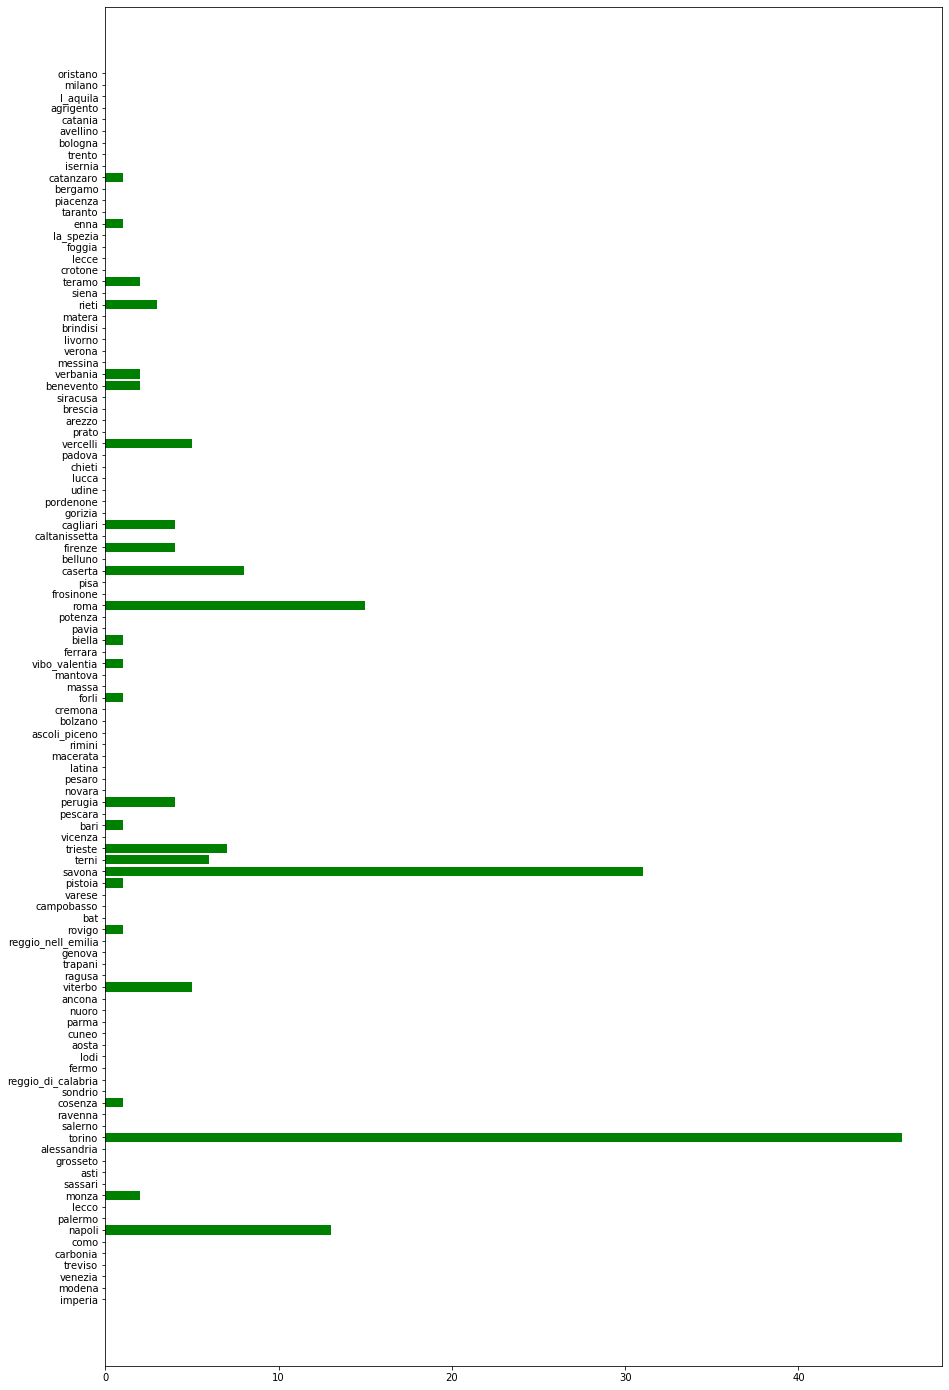

In [29]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(15, 25)
#fig.autofmt_xdate(rotation=45)
plt.barh(list(diffes.keys()), diffes.values(), color='g')

In [30]:
idx = 1
for prov in diffes:
    print(idx, " - ", prov, " ==> ", diffes[prov], " ", percdiffes[prov], "%")
    idx  += 1

1  -  imperia  ==>  0   0.0 %
2  -  modena  ==>  0   0.0 %
3  -  venezia  ==>  0   0.0 %
4  -  treviso  ==>  0   0.0 %
5  -  carbonia  ==>  0   0.0 %
6  -  como  ==>  0   0.0 %
7  -  napoli  ==>  13   8.873720136518772 %
8  -  palermo  ==>  0   0.0 %
9  -  lecco  ==>  0   0.0 %
10  -  monza  ==>  2   1.3888888888888888 %
11  -  sassari  ==>  0   0.0 %
12  -  asti  ==>  0   0.0 %
13  -  grosseto  ==>  0   0.0 %
14  -  alessandria  ==>  0   0.0 %
15  -  torino  ==>  46   14.024390243902438 %
16  -  salerno  ==>  0   0.0 %
17  -  ravenna  ==>  0   0.0 %
18  -  cosenza  ==>  1   9.523809523809524 %
19  -  sondrio  ==>  0   0.0 %
20  -  reggio_di_calabria  ==>  0   0.0 %
21  -  fermo  ==>  0   0.0 %
22  -  lodi  ==>  0   0.0 %
23  -  aosta  ==>  0   0.0 %
24  -  cuneo  ==>  0   0.0 %
25  -  parma  ==>  0   0.0 %
26  -  nuoro  ==>  0   0.0 %
27  -  ancona  ==>  0   0.0 %
28  -  viterbo  ==>  5   40.0 %
29  -  ragusa  ==>  0   0.0 %
30  -  trapani  ==>  0   0.0 %
31  -  genova  ==>  0   0.0 %

In [31]:
newparticulate = {}
for k in new_datapaper.columns:
    newparticulate[k] = new_datapaper[k].values.copy()

for idx, prov in enumerate(newparticulate["prov"]):
    if prov in casiperprov:
        newparticulate["Cases"][idx] = casiperprov[prov]
    else:
        newparticulate["Cases"][idx] = -1
    
    #print(casiperprov[prov])

dfnewparticulate = pd.DataFrame.from_dict(newparticulate)

dfnewparticulate = dfnewparticulate[dfnewparticulate.Cases != -1]

dfnewparticulate.to_csv("newparticulate_covidstat.csv", index=False, sep=";")

In [32]:
checkdatapaper = pd.read_csv("./newparticulate_covidstat.csv", sep=";")

for prov in provincelist:

    givenprov = checkdatapaper[checkdatapaper["prov"] == prov]
    if givenprov["Cases"].values[0] != casiperprov[prov]:
        print("Error in  :", prov)
   
